# 1. Setup & Installation

In [ ]:
# Install dependencies
!pip install -q timm huggingface_hub torchmetrics tqdm scikit-learn seaborn scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 17.8 MB/s eta 0:00:00


In [ ]:
# Standard imports
import os
import json
import pickle
import random
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    accuracy_score, precision_score, recall_score,
    confusion_matrix, roc_curve, precision_recall_curve,
    classification_report
)
from sklearn.calibration import calibration_curve

from scipy import ndimage
from skimage import morphology, measure
from skimage.morphology import skeletonize

import timm
from huggingface_hub import login

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

print(" All imports successful")

✅ All imports successful


In [ ]:
# Device and reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 2. Vessel Feature Extraction Module

Extract clinically validated features from vessel segmentation masks.

In [ ]:
def extract_clinical_vessel_features(vessel_mask):

    # Extract 15 clinically validated vessel features from segmentation mask.

    # Ensure binary
    mask = (vessel_mask > 0.5).astype(np.uint8)
    h, w = mask.shape

    features = {}

    # 1 DENSITY FEATURES (3 features)


    # Overall vessel density
    features['vessel_density'] = mask.mean()

    # Central vs peripheral density
    center_y, center_x = h // 2, w // 2
    y, x = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)

    radius_outer = min(h, w) // 3
    peripheral_mask = dist_from_center > radius_outer

    features['peripheral_density'] = mask[peripheral_mask].mean() if peripheral_mask.sum() > 0 else 0

    central_mask = dist_from_center <= radius_outer
    central_density = mask[central_mask].mean() if central_mask.sum() > 0 else 0

    # Density gradient
    if central_density > 0:
        features['density_gradient'] = features['peripheral_density'] / central_density
    else:
        features['density_gradient'] = 0


    # 2 MORPHOLOGICAL FEATURES (3 features)


    # Skeleton for morphological analysis
    skeleton = skeletonize(mask > 0).astype(np.uint8)
    skeleton_density = skeleton.mean()

    # Average vessel thickness
    if skeleton_density > 0:
        features['avg_vessel_thickness'] = features['vessel_density'] / skeleton_density
    else:
        features['avg_vessel_thickness'] = 0

    # Number of vessel segments
    labeled = measure.label(mask > 0)
    features['num_vessel_segments'] = labeled.max()

    # Spatial uniformity (quadrant analysis)
    h_mid, w_mid = h // 2, w // 2
    quadrants = [
        mask[:h_mid, :w_mid].mean(),
        mask[:h_mid, w_mid:].mean(),
        mask[h_mid:, :w_mid].mean(),
        mask[h_mid:, w_mid:].mean()
    ]
    features['spatial_uniformity'] = 1 - (np.std(quadrants) / (np.mean(quadrants) + 1e-8))

    # 3 TORTUOSITY FEATURES (2 features)


    labeled_skeleton = measure.label(skeleton)
    num_segments = labeled_skeleton.max()

    tortuosities = []
    if num_segments > 0:
        for i in range(1, min(num_segments + 1, 30)):
            segment = (labeled_skeleton == i)
            segment_length = segment.sum()

            if segment_length < 20:
                continue

            y_coords, x_coords = np.where(segment)
            if len(y_coords) < 3:
                continue

            try:
                coords = np.column_stack([x_coords, y_coords])
                mean_coord = coords.mean(axis=0)
                centered = coords - mean_coord
                cov = np.cov(centered.T)
                eigenvalues, eigenvectors = np.linalg.eig(cov)
                principal_axis = eigenvectors[:, np.argmax(eigenvalues)]
                projections = centered @ principal_axis
                chord_length = projections.max() - projections.min()

                if chord_length > 10:
                    tortuosity = (segment_length / chord_length) - 1
                    tortuosities.append(max(0, tortuosity))
            except:
                continue

    features['avg_tortuosity'] = np.mean(tortuosities) if len(tortuosities) > 0 else 0
    features['max_tortuosity'] = np.max(tortuosities) if len(tortuosities) > 0 else 0


    # 4 CALIBER (WIDTH) FEATURES (3 features)


    distance_map = ndimage.distance_transform_edt(mask)
    widths = distance_map[skeleton > 0] * 2

    if len(widths) > 0:
        features['avg_vessel_width'] = np.mean(widths)
        features['vessel_width_std'] = np.std(widths)
        features['width_cv'] = features['vessel_width_std'] / (features['avg_vessel_width'] + 1e-8)
    else:
        features['avg_vessel_width'] = 0
        features['vessel_width_std'] = 0
        features['width_cv'] = 0


    # 5 COMPLEXITY FEATURES (3 features)


    # Fractal dimension
    def box_count(image, box_size):
        h, w = image.shape
        count = 0
        for i in range(0, h, box_size):
            for j in range(0, w, box_size):
                box = image[i:min(i+box_size, h), j:min(j+box_size, w)]
                if box.sum() > 0:
                    count += 1
        return count

    sizes = [4, 8, 16, 32, 64]
    counts = []
    for size in sizes:
        count = box_count(mask, size)
        if count > 0:
            counts.append(count)
        else:
            break

    if len(counts) >= 3:
        try:
            valid_sizes = sizes[:len(counts)]
            coeffs = np.polyfit(np.log(valid_sizes), np.log(counts), 1)
            features['fractal_dimension'] = -coeffs[0]
        except:
            features['fractal_dimension'] = 0
    else:
        features['fractal_dimension'] = 0

    # Branching density
    kernel = np.ones((3, 3), dtype=np.uint8)
    neighbor_count = cv2.filter2D(skeleton.astype(np.float32), -1, kernel) - skeleton
    branch_points = ((neighbor_count >= 3) & (skeleton == 1)).sum()

    skeleton_length = skeleton.sum()
    features['branching_density'] = branch_points / (skeleton_length + 1e-8)

    # Connectivity index
    endpoints = ((neighbor_count == 1) & (skeleton == 1)).sum()
    features['connectivity_index'] = branch_points / (endpoints + 1e-8)


    # 6 TEXTURE (1 feature)


    kernel_size = 15
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size ** 2)
    mean_local = cv2.filter2D(mask.astype(np.float32), -1, kernel)
    mean_sq_local = cv2.filter2D((mask ** 2).astype(np.float32), -1, kernel)
    variance_local = mean_sq_local - mean_local ** 2
    features['texture_variance'] = variance_local.mean()

    # Create feature vector
    feature_vector = np.array([
        features['vessel_density'],
        features['peripheral_density'],
        features['density_gradient'],
        features['avg_vessel_thickness'],
        features['num_vessel_segments'],
        features['spatial_uniformity'],
        features['avg_tortuosity'],
        features['max_tortuosity'],
        features['avg_vessel_width'],
        features['vessel_width_std'],
        features['width_cv'],
        features['fractal_dimension'],
        features['branching_density'],
        features['connectivity_index'],
        features['texture_variance']
    ])

    return features, feature_vector

print(" Vessel feature extraction module loaded")

✅ Vessel feature extraction module loaded


# 3. Mount Google Drive & Define Paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define paths
DRIVE_BASE = Path('/content/drive/MyDrive')
CKPT_DIR = DRIVE_BASE

# Checkpoint paths
cimt_ckpt_path = CKPT_DIR / 'cimt_reg.pth'
htn_ckpt_path = CKPT_DIR / 'hypertension.pt'
vessel_ckpt_path = CKPT_DIR / 'vessel.pth'

# Output directory
OUTPUT_DIR = Path('/content/cvd_fusion_BEST')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("Paths configured:")
print(f" CIMT: {cimt_ckpt_path}")
print(f" HTN: {htn_ckpt_path}")
print(f" Vessel: {vessel_ckpt_path}")
print(f" Output: {OUTPUT_DIR}")

Paths configured:
  CIMT: /content/drive/MyDrive/cimt_reg.pth
  HTN: /content/drive/MyDrive/hypertension.pt
  Vessel: /content/drive/MyDrive/vessel.pth
  Output: /content/cvd_fusion_BEST


# 4. Download & Load Dataset

In [ ]:
import requests
import zipfile

DATA_ROOT = Path("/content/data/China_Fundus_CIMT")
DATA_ROOT.mkdir(parents=True, exist_ok=True)

def download_figshare_dataset(article_id=27907056, out_dir=DATA_ROOT):
    """Download China-Fundus-CIMT dataset from Figshare"""
    print(f"Downloading from Figshare article {article_id}...")

    # Get article metadata
    api_url = f"https://api.figshare.com/v2/articles/{article_id}"
    response = requests.get(api_url)
    response.raise_for_status()
    article_data = response.json()

    # Download all files
    for file_info in article_data['files']:
        file_url = file_info['download_url']
        file_name = file_info['name']
        file_path = out_dir / file_name

        if file_path.exists():
            print(f"{file_name} already exists")
            continue

        print(f" Downloading {file_name}...")
        r = requests.get(file_url, stream=True)
        r.raise_for_status()

        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

        if file_name.endswith('.zip'):
            print(f"  Extracting {file_name}...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(out_dir)

    print(" Dataset download complete")

# Download dataset
download_figshare_dataset()

  Extracting Fundus_CIMT_2903.zip...
✅ Dataset download complete


In [ ]:
# Load metadata
DATASET_FOLDER = DATA_ROOT / "Fundus_CIMT_2903 Dataset"
DATA_INFO_JSON = DATA_ROOT / "data_info.json"
IMAGES_DIR = DATASET_FOLDER

with open(DATA_INFO_JSON, 'r') as f:
    metadata_dict = json.load(f)

# Build dataframe
data_records = []
for patient_id, info in metadata_dict.items():
    right_img_name = info.get('right_eye', '')
    left_img_name = info.get('left_eye', '')

    right_img_path = IMAGES_DIR / right_img_name if right_img_name else None
    left_img_path = IMAGES_DIR / left_img_name if left_img_name else None

    right_exists = right_img_path.exists() if right_img_path else False
    left_exists = left_img_path.exists() if left_img_path else False

    if right_exists or left_exists:
        data_records.append({
            'patient_id': patient_id,
            'right_eye': right_img_name if right_exists else None,
            'left_eye': left_img_name if left_exists else None,
            'has_right': right_exists,
            'has_left': left_exists,
            'has_both': right_exists and left_exists,
            'cimt_mm': float(info.get('thickness', np.nan)),
            'age': int(info.get('True_age', -1)),
            'gender': info.get('gender', -1)
        })

df = pd.DataFrame(data_records)
df = df.dropna(subset=['cimt_mm']).reset_index(drop=True)

# Create CVD risk labels
CIMT_THRESHOLD = 0.908
df['cvd_risk'] = (df['cimt_mm'] >= CIMT_THRESHOLD).astype(int)

print(f" Loaded {len(df)} patients")
print(f"\nCVD Risk Distribution:")
print(f" High risk: {(df['cvd_risk']==1).sum()} ({(df['cvd_risk']==1).mean()*100:.1f}%)")
print(f" Low risk:  {(df['cvd_risk']==0).sum()} ({(df['cvd_risk']==0).mean()*100:.1f}%)")

✅ Loaded 2903 patients

CVD Risk Distribution:
  High risk: 1671 (57.6%)
  Low risk:  1232 (42.4%)


# 5. Split Data BEFORE Feature Extraction

**Critical:** Split first to prevent data leakage!

In [ ]:
# Stratified split
train_idx, temp_idx = train_test_split(
    np.arange(len(df)),
    test_size=0.2,
    stratify=df['cvd_risk'].values,
    random_state=SEED
)

val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=df.iloc[temp_idx]['cvd_risk'].values,
    random_state=SEED
)

df_train = df.iloc[train_idx].reset_index(drop=True)
df_val = df.iloc[val_idx].reset_index(drop=True)
df_test = df.iloc[test_idx].reset_index(drop=True)

print("Dataset splits:")
print("="*60)
print(f"Train: {len(df_train)} samples, pos rate: {df_train['cvd_risk'].mean():.2%}")
print(f"Val:   {len(df_val)} samples, pos rate: {df_val['cvd_risk'].mean():.2%}")
print(f"Test:  {len(df_test)} samples, pos rate: {df_test['cvd_risk'].mean():.2%}")

# Verify no overlap
assert len(set(train_idx) & set(val_idx)) == 0
assert len(set(train_idx) & set(test_idx)) == 0
assert len(set(val_idx) & set(test_idx)) == 0
print("\n No data leakage - splits are disjoint")

Dataset splits:
Train: 2322 samples, pos rate: 57.58%
Val:   290 samples, pos rate: 57.59%
Test:  291 samples, pos rate: 57.39%

✅ No data leakage - splits are disjoint


# 6. Load Pretrained Models

In [ ]:
from huggingface_hub import login

HF_TOKEN = ""
login(HF_TOKEN)

## 6.1 HTN Model

In [ ]:
class RETFoundClassifier(nn.Module):
    def __init__(self, dropout=0.65):
        super().__init__()
        self.backbone = timm.create_model(
            "vit_large_patch16_224",
            pretrained=False,
            num_classes=0,
            global_pool='token'
        )
        embed_dim = self.backbone.num_features
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, 1)
        )

    def forward(self, x, return_embedding=False):
        features = self.backbone(x)
        logits = self.head(features)
        if return_embedding:
            return logits, features
        return logits

# Load model
from huggingface_hub import hf_hub_download

print("Loading HTN model...")
retfound_ckpt_path = hf_hub_download(
    repo_id="YukunZhou/RETFound_mae_natureCFP",
    filename="RETFound_mae_natureCFP.pth",
    cache_dir="/tmp/.cache"
)

htn_model = RETFoundClassifier(dropout=0.65).to(device)

# Load RETFound backbone
retfound_ckpt = torch.load(retfound_ckpt_path, map_location=device, weights_only=False)
retfound_state = retfound_ckpt["model"] if "model" in retfound_ckpt else retfound_ckpt

backbone_state_dict = {}
for key, value in retfound_state.items():
    if not key.startswith("decoder"):
        new_key = key.replace("encoder.", "")
        backbone_state_dict[new_key] = value

htn_model.backbone.load_state_dict(backbone_state_dict, strict=False)

# Load fine-tuned weights
htn_ckpt = torch.load(htn_ckpt_path, map_location=device, weights_only=False)
state_dict = htn_ckpt.get('model', htn_ckpt.get('model_state_dict', htn_ckpt))
htn_model.load_state_dict(state_dict, strict=False)

htn_model.eval()
for p in htn_model.parameters():
    p.requires_grad = False

print(" HTN model loaded")

Loading HTN model...


RETFound_mae_natureCFP.pth:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

✅ HTN model loaded


## 6.2 CIMT Model

In [ ]:
class SiameseMultimodalCIMTRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
            "seresnext50_32x4d",
            pretrained=True,
            num_classes=0,
            global_pool='avg'
        )
        backbone_out_dim = self.backbone.num_features

        CLINICAL_INPUT_DIM = 3
        CLINICAL_HIDDEN_DIM = 128
        DROPOUT_RATE = 0.5

        self.clinical_fc = nn.Sequential(
            nn.Linear(CLINICAL_INPUT_DIM, CLINICAL_HIDDEN_DIM),
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE)
        )

        fusion_input_dim = backbone_out_dim * 2 + CLINICAL_HIDDEN_DIM
        FUSION_HIDDEN_DIMS = [512, 128]

        layers = []
        in_dim = fusion_input_dim
        for hidden_dim in FUSION_HIDDEN_DIMS:
            layers.extend([
                nn.Linear(in_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(DROPOUT_RATE)
            ])
            in_dim = hidden_dim

        layers.append(nn.Linear(in_dim, 1))
        self.fusion = nn.Sequential(*layers)

    def forward(self, left_img, right_img, clinical, return_embedding=False):
        left_features = self.backbone(left_img)
        right_features = self.backbone(right_img)
        bilateral_features = torch.cat([left_features, right_features], dim=1)
        clinical_features = self.clinical_fc(clinical)
        fused = torch.cat([bilateral_features, clinical_features], dim=1)

        if return_embedding:
            embedding = fused
            for layer in self.fusion[:-1]:
                embedding = layer(embedding)
            prediction = self.fusion[-1](embedding)
            return prediction, embedding

        return self.fusion(fused)

# Load model
print("Loading CIMT model...")
cimt_model = SiameseMultimodalCIMTRegression().to(device)

cimt_ckpt = torch.load(cimt_ckpt_path, map_location=device, weights_only=False)
state_dict = cimt_ckpt.get('model_state_dict', cimt_ckpt.get('state_dict', cimt_ckpt))
cimt_model.load_state_dict(state_dict)

cimt_model.eval()
for p in cimt_model.parameters():
    p.requires_grad = False

print(" CIMT model loaded")

Loading CIMT model...


model.safetensors:   0%|          | 0.00/111M [00:00<?, ?B/s]

✅ CIMT model loaded


## 6.3 Vessel Model

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super().__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(in_ch, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = CBR(256+128, 128)
        self.dec2 = CBR(128+64, 64)
        self.final = nn.Conv2d(64, out_ch, 1)

    def forward(self, x, return_features=False):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        if return_features:
            features = F.adaptive_avg_pool2d(e3, (1, 1)).flatten(1)
            return features

        d3 = self.up(e3)
        d3 = self.dec3(torch.cat([d3, e2], dim=1))
        d2 = self.up(d3)
        d2 = self.dec2(torch.cat([d2, e1], dim=1))
        return self.final(d2)

# Load model
print("Loading vessel model...")
vessel_model = UNet(in_ch=3, out_ch=1).to(device)

vessel_ckpt = torch.load(vessel_ckpt_path, map_location=device, weights_only=False)
vessel_model.load_state_dict(vessel_ckpt['model_state_dict'])

vessel_model.eval()
for p in vessel_model.parameters():
    p.requires_grad = False

print(" Vessel model loaded")

Loading vessel model...
✅ Vessel model loaded


# 7. Define Transforms

In [ ]:
transform_htn = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_cimt = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_vessel = transforms.Compose([
    transforms.Resize((512, 512), interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print(" Transforms defined")

✅ Transforms defined


# 8. Enhanced Feature Extraction

Extract features separately for each split with enhanced vessel features.

In [ ]:
def extract_enhanced_features(df_subset, images_dir, split_name=""):

    # Build a unified feature vector for the fusion model:
    # HTN model: 1 probability + 1024-dim embedding
    # CIMT model: 1 output + 128-dim embedding
    # Vessel model: 256 learned + 15 handcrafted features
    # Total fused feature dimension = 1425

    print(f"\n{'='*80}")
    print(f"EXTRACTING FEATURES FOR {split_name} SET")
    print(f"{'='*80}")

    N = len(df_subset)

    # Preallocate
    htn_probs = np.zeros(N, dtype=np.float32)
    htn_embeddings = np.zeros((N, 1024), dtype=np.float32)
    cimt_preds = np.zeros(N, dtype=np.float32)
    cimt_embeddings = np.zeros((N, 128), dtype=np.float32)
    vessel_learned = np.zeros((N, 256), dtype=np.float32)
    vessel_handcrafted = np.zeros((N, 15), dtype=np.float32)

    htn_model.eval()
    cimt_model.eval()
    vessel_model.eval()

    with torch.no_grad():
        for idx, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc=f"Extracting {split_name}"):
            # Load images
            left_img_path = images_dir / row['left_eye'] if pd.notna(row['left_eye']) else None
            right_img_path = images_dir / row['right_eye'] if pd.notna(row['right_eye']) else None

            left_img = Image.open(left_img_path).convert('RGB') if left_img_path and left_img_path.exists() else None
            right_img = Image.open(right_img_path).convert('RGB') if right_img_path and right_img_path.exists() else None

            # Fallback for missing eyes
            if left_img is None and right_img is not None:
                left_img = right_img
            elif right_img is None and left_img is not None:
                right_img = left_img

            if left_img is None or right_img is None:
                continue

            # HTN FEATURES Extract embeddings manually from backbone

            htn_probs_list = []
            htn_emb_list = []

            for img in [left_img, right_img]:
                img_htn = transform_htn(img).unsqueeze(0).to(device)

                # Get backbone features manually
                backbone_features = htn_model.backbone.forward_features(img_htn)
                if backbone_features.ndim == 3:
                    backbone_features = backbone_features.mean(dim=1)

                # Get logits from classifier
                logits = htn_model.head(backbone_features)
                prob = torch.sigmoid(logits).cpu().numpy()[0, 0]

                htn_probs_list.append(prob)
                htn_emb_list.append(backbone_features.cpu().numpy()[0])

            htn_probs[idx] = np.mean(htn_probs_list)
            htn_embeddings[idx] = np.mean(htn_emb_list, axis=0)


            # CIMT FEATURES  Extract embeddings from fusion layers

            left_cimt = transform_cimt(left_img).unsqueeze(0).to(device)
            right_cimt = transform_cimt(right_img).unsqueeze(0).to(device)

            metadata = torch.tensor(
                [[row['age'] / 100.0, 1.0 if row['gender'] == 1 else 0.0, 0.0]],
                dtype=torch.float32
            ).to(device)

            # Extract features manually
            left_features = cimt_model.backbone(left_cimt)
            right_features = cimt_model.backbone(right_cimt)
            bilateral_features = torch.cat([left_features, right_features], dim=1)
            clinical_features = cimt_model.clinical_fc(metadata)
            fused = torch.cat([bilateral_features, clinical_features], dim=1)

            # Pass through fusion layers to get embedding (all but last layer)
            embedding = fused
            for layer in cimt_model.fusion[:-1]:  r
                embedding = layer(embedding)

            # Final output
            cimt_pred = cimt_model.fusion[-1](embedding)

            cimt_preds[idx] = cimt_pred.cpu().numpy()[0, 0]
            cimt_embeddings[idx] = embedding.cpu().numpy()[0]

            # VESSEL FEATURES Extract from encoder manually

            vessel_learned_list = []
            vessel_handcrafted_list = []

            for img in [left_img, right_img]:
                img_vessel = transform_vessel(img).unsqueeze(0).to(device)

                # Get encoder features manually
                e1 = vessel_model.enc1(img_vessel)
                e2 = vessel_model.enc2(vessel_model.pool(e1))
                e3 = vessel_model.enc3(vessel_model.pool(e2))

                # Extract learned features from e3
                learned_feat = F.adaptive_avg_pool2d(e3, (1, 1)).flatten(1)
                vessel_learned_list.append(learned_feat.cpu().numpy()[0])

                # Get full segmentation for handcrafted features
                d3 = vessel_model.up(e3)
                d3 = vessel_model.dec3(torch.cat([d3, e2], dim=1))
                d2 = vessel_model.up(d3)
                d2 = vessel_model.dec2(torch.cat([d2, e1], dim=1))
                vessel_mask = vessel_model.final(d2)
                vessel_mask = torch.sigmoid(vessel_mask).cpu().numpy()[0, 0]

                # Extract handcrafted clinical features
                _, handcrafted_feat = extract_clinical_vessel_features(vessel_mask)
                vessel_handcrafted_list.append(handcrafted_feat)

            vessel_learned[idx] = np.mean(vessel_learned_list, axis=0)
            vessel_handcrafted[idx] = np.mean(vessel_handcrafted_list, axis=0)

    # Build fusion feature matrix
    X_fusion = np.concatenate([
        htn_probs[:, np.newaxis],
        htn_embeddings,
        cimt_preds[:, np.newaxis],
        cimt_embeddings,
        vessel_learned,
        vessel_handcrafted
    ], axis=1)

    y = df_subset['cvd_risk'].values

    print(f"\n Feature extraction complete for {split_name}")
    print(f"   Features shape: {X_fusion.shape}")
    print(f"   Breakdown: HTN(1025) + CIMT(129) + Vessel(271) = 1425")
    print(f"   Labels shape: {y.shape}")
    print(f"   Positive rate: {y.mean():.2%}")

    return X_fusion, y

# Extract for all splits
X_train_fusion, y_train = extract_enhanced_features(df_train, IMAGES_DIR, "TRAIN")
X_val_fusion, y_val = extract_enhanced_features(df_val, IMAGES_DIR, "VAL")
X_test_fusion, y_test = extract_enhanced_features(df_test, IMAGES_DIR, "TEST")


EXTRACTING FEATURES FOR TRAIN SET


Extracting TRAIN: 100%|██████████| 2322/2322 [20:47<00:00,  1.86it/s]



✅ Feature extraction complete for TRAIN
   Features shape: (2322, 1425)
   Breakdown: HTN(1025) + CIMT(129) + Vessel(271) = 1425
   Labels shape: (2322,)
   Positive rate: 57.58%

EXTRACTING FEATURES FOR VAL SET


Extracting VAL: 100%|██████████| 290/290 [02:31<00:00,  1.91it/s]



✅ Feature extraction complete for VAL
   Features shape: (290, 1425)
   Breakdown: HTN(1025) + CIMT(129) + Vessel(271) = 1425
   Labels shape: (290,)
   Positive rate: 57.59%

EXTRACTING FEATURES FOR TEST SET


Extracting TEST: 100%|██████████| 291/291 [02:30<00:00,  1.93it/s]


✅ Feature extraction complete for TEST
   Features shape: (291, 1425)
   Breakdown: HTN(1025) + CIMT(129) + Vessel(271) = 1425
   Labels shape: (291,)
   Positive rate: 57.39%


# 9. Extract Modality-Specific Features

In [ ]:
# HTN features
X_htn_train = X_train_fusion[:, :1025]
X_htn_val = X_val_fusion[:, :1025]
X_htn_test = X_test_fusion[:, :1025]

# CIMT features
X_cimt_train = X_train_fusion[:, 1025:1154]
X_cimt_val = X_val_fusion[:, 1025:1154]
X_cimt_test = X_test_fusion[:, 1025:1154]

# Vessel features
X_vessel_train = X_train_fusion[:, 1154:]
X_vessel_val = X_val_fusion[:, 1154:]
X_vessel_test = X_test_fusion[:, 1154:]

print("Modality-specific feature shapes:")
print(f"  HTN:    {X_htn_train.shape}")
print(f"  CIMT:   {X_cimt_train.shape}")
print(f"  Vessel: {X_vessel_train.shape} (enhanced from 1 to 271!)")

Modality-specific feature shapes:
  HTN:    (2322, 1025)
  CIMT:   (2322, 129)
  Vessel: (2322, 271) (enhanced from 1 to 271!)


# 10. Feature Normalization

In [ ]:
def standardize_features(X_train, X_val, X_test):
    mean = X_train.mean(axis=0, keepdims=True)
    std = X_train.std(axis=0, keepdims=True) + 1e-8

    X_train_std = (X_train - mean) / std
    X_val_std = (X_val - mean) / std
    X_test_std = (X_test - mean) / std

    return X_train_std, X_val_std, X_test_std, mean, std

# Standardize all features
X_train_fusion_std, X_val_fusion_std, X_test_fusion_std, fusion_mean, fusion_std = \
    standardize_features(X_train_fusion, X_val_fusion, X_test_fusion)

X_htn_train_std, X_htn_val_std, X_htn_test_std, _, _ = \
    standardize_features(X_htn_train, X_htn_val, X_htn_test)

X_cimt_train_std, X_cimt_val_std, X_cimt_test_std, _, _ = \
    standardize_features(X_cimt_train, X_cimt_val, X_cimt_test)

X_vessel_train_std, X_vessel_val_std, X_vessel_test_std, _, _ = \
    standardize_features(X_vessel_train, X_vessel_val, X_vessel_test)

print(" All features standardized using train statistics only")

✅ All features standardized using train statistics only


# 11. Compute Class Weights

In [ ]:
num_pos = (y_train == 1).sum()
num_neg = (y_train == 0).sum()
pos_weight = num_neg / num_pos

print(f"Class distribution:")
print(f"  Positive: {num_pos}")
print(f"  Negative: {num_neg}")
print(f"  pos_weight: {pos_weight:.3f}")

Class distribution:
  Positive: 1337
  Negative: 985
  pos_weight: 0.737


# 12. Train Baseline Models

In [ ]:
class SimpleMLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, dropout=0.3):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.mlp(x)

def train_baseline_model(X_train, X_val, y_train, y_val, model_name, input_dim,
                        num_epochs=30, lr=1e-3):
    print(f"\n{'='*80}")
    print(f"Training {model_name}")
    print(f"{'='*80}")

    model = SimpleMLPClassifier(input_dim, hidden_dim=256, dropout=0.3).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)

    best_val_auc = 0.0
    best_state = None

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        logits = model(X_train_t)
        loss = criterion(logits, y_train_t)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_logits = model(X_val_t)
            val_loss = criterion(val_logits, y_val_t)
            val_probs = torch.sigmoid(val_logits).cpu().numpy()

        val_auc = roc_auc_score(y_val, val_probs)

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_state = model.state_dict()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Loss: {loss.item():.4f} | Val AUC: {val_auc:.4f}")

    model.load_state_dict(best_state)
    print(f" Best Val AUC: {best_val_auc:.4f}")

    return model, best_val_auc

# Train baselines
htn_baseline, htn_val_auc = train_baseline_model(
    X_htn_train_std, X_htn_val_std, y_train, y_val,
    "HTN-only", input_dim=1025
)

cimt_baseline, cimt_val_auc = train_baseline_model(
    X_cimt_train_std, X_cimt_val_std, y_train, y_val,
    "CIMT-only", input_dim=129
)

vessel_baseline, vessel_val_auc = train_baseline_model(
    X_vessel_train_std, X_vessel_val_std, y_train, y_val,
    "Vessel-only (Enhanced)", input_dim=271
)


Training HTN-only
Epoch 10/30 | Loss: 0.4506 | Val AUC: 0.8324
Epoch 20/30 | Loss: 0.4048 | Val AUC: 0.8330
Epoch 30/30 | Loss: 0.3952 | Val AUC: 0.8290
✅ Best Val AUC: 0.8401

Training CIMT-only
Epoch 10/30 | Loss: 0.4540 | Val AUC: 0.8146
Epoch 20/30 | Loss: 0.4389 | Val AUC: 0.8173
Epoch 30/30 | Loss: 0.4390 | Val AUC: 0.8222
✅ Best Val AUC: 0.8222

Training Vessel-only (Enhanced)
Epoch 10/30 | Loss: 0.4984 | Val AUC: 0.7794
Epoch 20/30 | Loss: 0.4764 | Val AUC: 0.8075
Epoch 30/30 | Loss: 0.4593 | Val AUC: 0.8122
✅ Best Val AUC: 0.8122


# 13. Train Fusion Model

In [ ]:
class FusionMetaClassifier(nn.Module):
    def __init__(self, input_dim=1425, hidden_dims=[512, 256], dropout=0.3):
        super().__init__()

        layers = []
        in_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(in_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            in_dim = hidden_dim

        layers.append(nn.Linear(in_dim, 1))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

# Initialize
fusion_model = FusionMetaClassifier(
    input_dim=1425,
    hidden_dims=[512, 256],
    dropout=0.3
).to(device)

print(f"Fusion model:")
print(f"  Input: 1425 features")
print(f"  Hidden: [512, 256]")
print(f"  Parameters: {sum(p.numel() for p in fusion_model.parameters()):,}")

Fusion model:
  Input: 1425 features
  Hidden: [512, 256]
  Parameters: 861,697


In [ ]:
# Train fusion
print("\n" + "="*80)
print("Training Fusion Meta-Classifier")
print("="*80)

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))
optimizer = optim.Adam(fusion_model.parameters(), lr=1e-3, weight_decay=1e-5)

X_train_t = torch.tensor(X_train_fusion_std, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_val_t = torch.tensor(X_val_fusion_std, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)

NUM_EPOCHS = 30
best_val_auc = 0.0
best_fusion_state = None
training_history = []

for epoch in range(NUM_EPOCHS):
    fusion_model.train()
    optimizer.zero_grad()
    logits = fusion_model(X_train_t)
    loss = criterion(logits, y_train_t)
    loss.backward()
    optimizer.step()

    fusion_model.eval()
    with torch.no_grad():
        val_logits = fusion_model(X_val_t)
        val_loss = criterion(val_logits, y_val_t)
        val_probs = torch.sigmoid(val_logits).cpu().numpy()

    val_auc = roc_auc_score(y_val, val_probs)
    val_pr_auc = average_precision_score(y_val, val_probs)

    training_history.append({
        'epoch': epoch + 1,
        'train_loss': loss.item(),
        'val_loss': val_loss.item(),
        'val_auc': val_auc,
        'val_pr_auc': val_pr_auc
    })

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_fusion_state = fusion_model.state_dict()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {loss.item():.4f} | Val AUC: {val_auc:.4f}")

fusion_model.load_state_dict(best_fusion_state)
print(f"\n Best Val AUC: {best_val_auc:.4f}")


Training Fusion Meta-Classifier
Epoch 10/30 | Loss: 0.4102 | Val AUC: 0.8410
Epoch 20/30 | Loss: 0.3858 | Val AUC: 0.8396
Epoch 30/30 | Loss: 0.3609 | Val AUC: 0.8275

✅ Best Val AUC: 0.8416


# 14. Comprehensive Evaluation

In [ ]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    model.eval()
    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

    with torch.no_grad():
        logits = model(X_test_t)
        probs = torch.sigmoid(logits).cpu().numpy().flatten()

    preds = (probs >= 0.5).astype(int)

    metrics = {
        'auc': roc_auc_score(y_test, probs),
        'pr_auc': average_precision_score(y_test, probs),
        'f1': f1_score(y_test, preds),
        'accuracy': accuracy_score(y_test, preds),
        'precision': precision_score(y_test, preds, zero_division=0),
        'recall': recall_score(y_test, preds, zero_division=0),
        'probs': probs
    }

    print(f"\n{'='*80}")
    print(f"{model_name} - TEST SET RESULTS")
    print(f"{'='*80}")
    print(f"ROC-AUC:     {metrics['auc']:.4f}")
    print(f"PR-AUC:      {metrics['pr_auc']:.4f}")
    print(f"F1-Score:    {metrics['f1']:.4f}")
    print(f"Accuracy:    {metrics['accuracy']:.4f}")
    print(f"Precision:   {metrics['precision']:.4f}")
    print(f"Recall:      {metrics['recall']:.4f}")

    return metrics

# Evaluate all models
results = {}
results['fusion'] = evaluate_model(fusion_model, X_test_fusion_std, y_test, "FUSION (Enhanced)")
results['htn'] = evaluate_model(htn_baseline, X_htn_test_std, y_test, "HTN-ONLY")
results['cimt'] = evaluate_model(cimt_baseline, X_cimt_test_std, y_test, "CIMT-ONLY")
results['vessel'] = evaluate_model(vessel_baseline, X_vessel_test_std, y_test, "VESSEL-ONLY (Enhanced)")


FUSION (Enhanced) - TEST SET RESULTS
ROC-AUC:     0.8124
PR-AUC:      0.8488
F1-Score:    0.7554
Accuracy:    0.7285
Precision:   0.7821
Recall:      0.7305

HTN-ONLY - TEST SET RESULTS
ROC-AUC:     0.8073
PR-AUC:      0.8463
F1-Score:    0.7730
Accuracy:    0.7457
Precision:   0.7925
Recall:      0.7545

CIMT-ONLY - TEST SET RESULTS
ROC-AUC:     0.8065
PR-AUC:      0.8363
F1-Score:    0.7826
Accuracy:    0.7595
Precision:   0.8129
Recall:      0.7545

VESSEL-ONLY (Enhanced) - TEST SET RESULTS
ROC-AUC:     0.7537
PR-AUC:      0.7965
F1-Score:    0.7160
Accuracy:    0.6838
Precision:   0.7389
Recall:      0.6946


# 15. Results Summary & Comparison

In [ ]:
# Create comparison table
comparison_df = pd.DataFrame([
    {'Model': 'Fusion (Enhanced)', **{k: v for k, v in results['fusion'].items() if k != 'probs'}},
    {'Model': 'HTN-only', **{k: v for k, v in results['htn'].items() if k != 'probs'}},
    {'Model': 'CIMT-only', **{k: v for k, v in results['cimt'].items() if k != 'probs'}},
    {'Model': 'Vessel-only (Enhanced)', **{k: v for k, v in results['vessel'].items() if k != 'probs'}}
])

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON (TEST SET)")
print("="*80)
print(comparison_df.to_string(index=False))

# Calculate improvements
best_baseline_auc = max(results['htn']['auc'], results['cimt']['auc'], results['vessel']['auc'])
fusion_improvement = ((results['fusion']['auc'] - best_baseline_auc) / best_baseline_auc) * 100

print(f"\n{'='*80}")
print("FUSION IMPROVEMENT ANALYSIS")
print(f"{'='*80}")
print(f"Best baseline AUC: {best_baseline_auc:.4f}")
print(f"Fusion AUC: {results['fusion']['auc']:.4f}")
print(f"Absolute improvement: +{results['fusion']['auc'] - best_baseline_auc:.4f}")
print(f"Relative improvement: +{fusion_improvement:.2f}%")

# Save results
comparison_df.to_csv(OUTPUT_DIR / 'model_comparison_ENHANCED.csv', index=False)
with open(OUTPUT_DIR / 'all_results_ENHANCED.pkl', 'wb') as f:
    pickle.dump(results, f)

print(f"\n Results saved to {OUTPUT_DIR}")


COMPREHENSIVE MODEL COMPARISON (TEST SET)
                 Model      auc   pr_auc       f1  accuracy  precision   recall
     Fusion (Enhanced) 0.812440 0.848807 0.755418  0.728522   0.782051 0.730539
              HTN-only 0.807321 0.846347 0.773006  0.745704   0.792453 0.754491
             CIMT-only 0.806452 0.836315 0.782609  0.759450   0.812903 0.754491
Vessel-only (Enhanced) 0.753718 0.796521 0.716049  0.683849   0.738854 0.694611

FUSION IMPROVEMENT ANALYSIS
Best baseline AUC: 0.8073
Fusion AUC: 0.8124
Absolute improvement: +0.0051
Relative improvement: +0.63%

✅ Results saved to /content/cvd_fusion_BEST


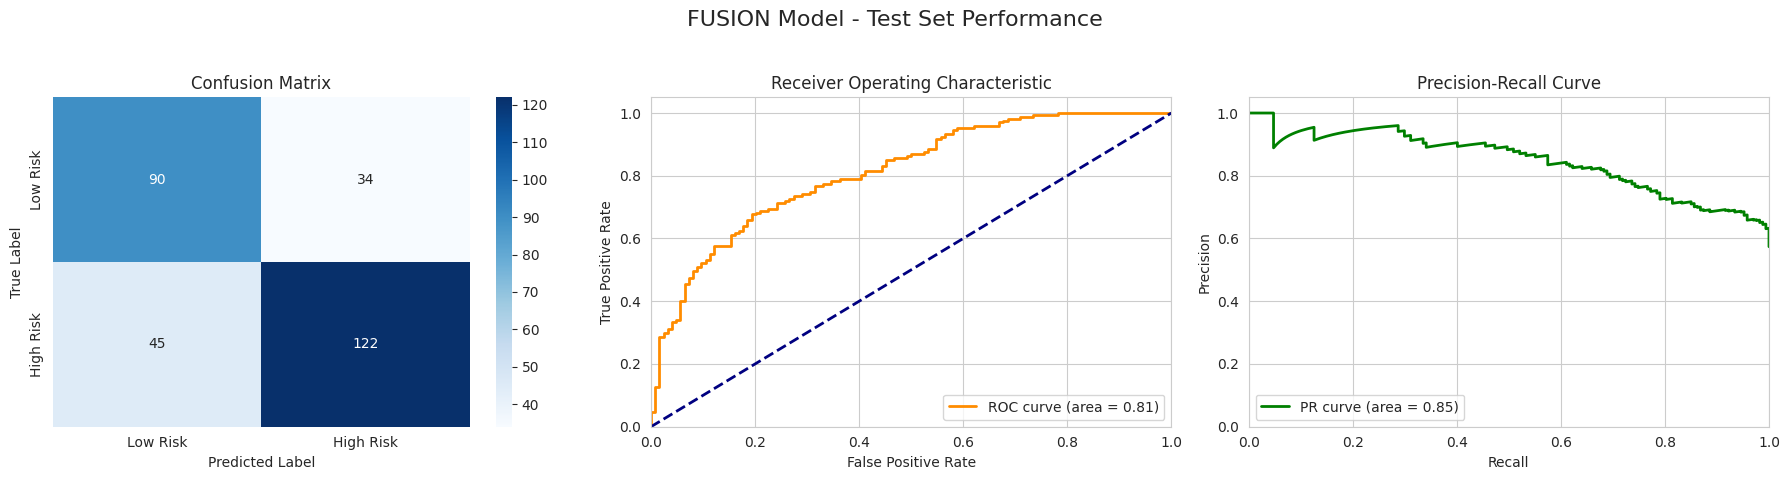

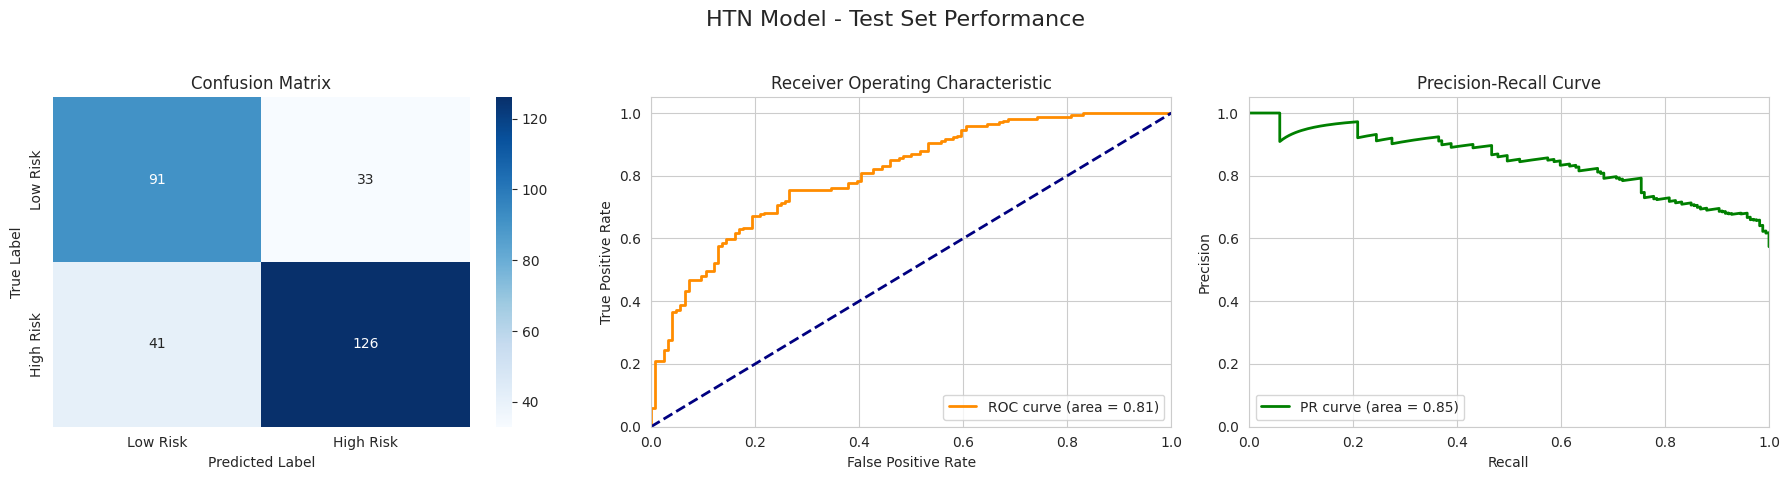

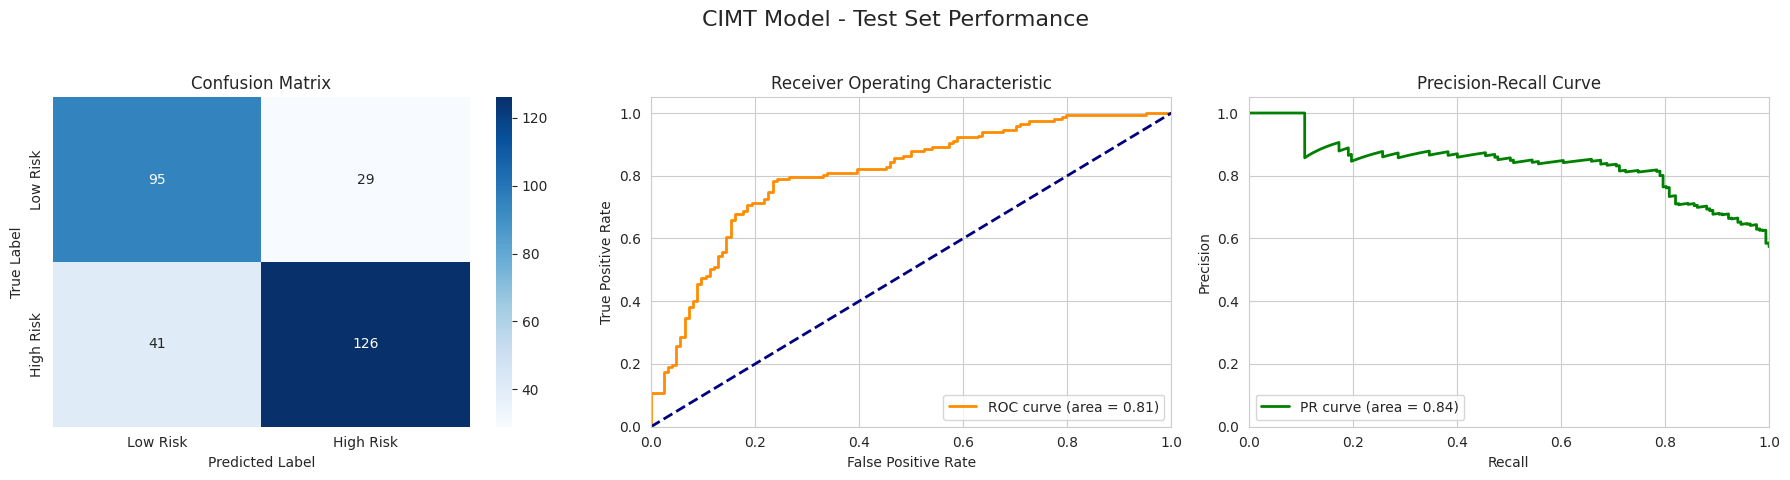

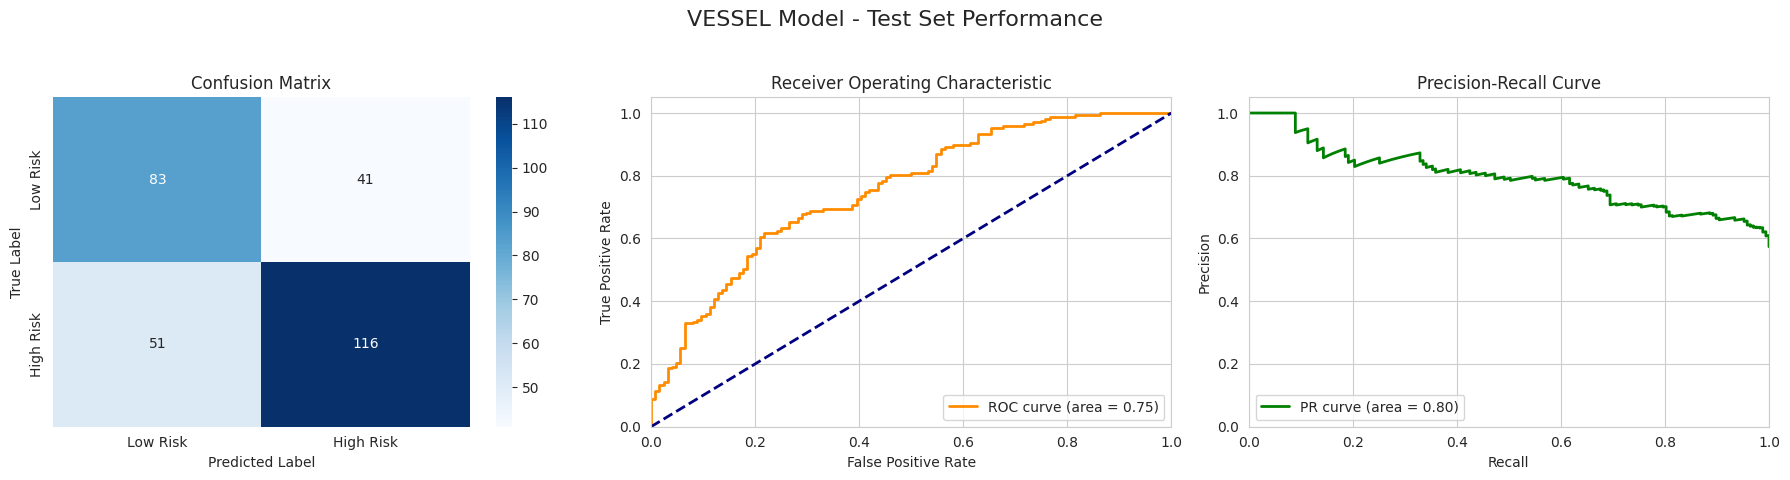

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

def plot_metrics(y_true, probs, model_name):
    preds = (probs >= 0.5).astype(int)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'{model_name} - Test Set Performance', fontsize=16)

    # Confusion Matrix
    cm = confusion_matrix(y_true, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Receiver Operating Characteristic')
    axes[1].legend(loc='lower right')

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, probs)
    pr_auc = auc(recall, precision)
    axes[2].plot(recall, precision, color='green', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    axes[2].set_xlim([0.0, 1.0])
    axes[2].set_ylim([0.0, 1.05])
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].set_title('Precision-Recall Curve')
    axes[2].legend(loc='lower left')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot for ALL Models
for model_name, model_results in results.items():
    plot_metrics(y_test, model_results['probs'], model_name.upper() + ' Model')


# 17. Save Models

In [ ]:
# Save fusion model checkpoint
import os
from datetime import datetime

# Create timestamp for versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save complete checkpoint with all training info
checkpoint = {
    'model_state_dict': fusion_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_auc': best_val_auc,
    'training_history': training_history,
    'model_config': {
        'input_dim': 1425,
        'hidden_dims': [512, 256],
        'dropout': 0.3
    },
    'standardization': {
        'fusion_mean': fusion_mean,
        'fusion_std': fusion_std
    },
    'timestamp': timestamp
}

# Save to current directory
checkpoint_path = f'fusion_cvd_model_{timestamp}.pth'
torch.save(checkpoint, checkpoint_path)
print(f" Saved complete checkpoint: {checkpoint_path}")
print(f" File size: {os.path.getsize(checkpoint_path) / (1024*1024):.2f} MB")

# Also save just the model weights
model_only_path = f'fusion_cvd_weights_{timestamp}.pth'
torch.save(fusion_model.state_dict(), model_only_path)
print(f" Saved model weights only: {model_only_path}")
print(f" File size: {os.path.getsize(model_only_path) / (1024*1024):.2f} MB")

if 'drive' in os.listdir('/content'):
    drive_path = f'/content/drive/MyDrive/fusion_cvd_model_{timestamp}.pth'
    torch.save(checkpoint, drive_path)
    print(f" Also saved to Google Drive: {drive_path}")

✅ Saved complete checkpoint: fusion_cvd_model_20251209_125850.pth
   File size: 9.89 MB
✅ Saved model weights only: fusion_cvd_weights_20251209_125850.pth
   File size: 3.29 MB
✅ Also saved to Google Drive: /content/drive/MyDrive/fusion_cvd_model_20251209_125850.pth
